# Reproduction of Shape Reconstruction method (Neural Spline) proposed By Williams et al. 2021

Here, we are going to reproduce Williams et al. methods for shape reconstruction 

Given $\mathcal{X} = \{x_1, \dots, x_k \}$ and $\mathcal{N} = \{n_1,\dots, n_k\}$ and $\mathcal{Y} = \{y_1, \dots, y_k\}$,  $\forall y_i = 0$

* Define $\mathcal{X}_{\delta}^- = \{x_1 - \delta n_1, \dots , x_k - \delta n_k\}$ and $\mathcal{X}_{\delta}^+ = \{x_1 + \delta n_1, \dots , x_k + \delta n_k\}$ and $\mathcal{Y}_{\delta}^- = \{-\delta, \dots, -\delta\}$ and $\mathcal{Y}_{\delta}^+= \{\delta, \dots,\delta\}$ in similar manner
* With union of the sets $\hat{\mathcal{X}} = \mathcal{X} \cup \mathcal{X}_{\delta}^- \cup \mathcal{X}_{\delta}^+$ and $\hat{\mathcal{Y}} = \mathcal{Y} \cup \mathcal{Y}_{\delta}^- \cup \mathcal{Y}_{\delta}^+$, training data tuple $(\hat{\mathcal{X}}, \hat{\mathcal{Y}})$ defines the \textbf{implicit representation of geometric surface}.



Let's defiine a regular voxel grids $\mathcal{X}_{test}$ on which all the extneded point clouds $\hat{\mathcal{X}}$ lie.

Then the signed distance corresponding the regular grid $\mathcal{X}_{test}$ can be computed by kernel regression with NTK as follow 


\begin{equation}
Y_{test} = K_{(test,train)}  (K_{(train,train)} + \lambda I )^{-1}  Y_{train}
\end{equation}

where, $Y_{train}$ and $Y_{test}$ are the signed distances for the extended point clouds and the regular grids, respectively. 


![alt text](implicit2.png "Concept")




In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='0'
import time
import jax 
from absl import app
from absl import flags
import jax.numpy as np
import neural_tangents as nt
from neural_tangents import stax
from examples import datasets
from examples import util
from neural_tangents.utils.kernel import Kernel
import numpy as onp
from jax import random
# double precision otherwise it may return NaN
from jax.config import config ; config.update('jax_enable_x64', True)
import sys

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
from utils import *
from util import Prod
from skimage import measure
import trimesh 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import open3d as o3d

gpu
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data
In this example, we are going to reconstruct a cup from ModelNet40 dataset. 

The original ModelNet40 dataset is in mesh format. Here, we are going to use a Point Cloud version that processed by  PointNet++ authors (Charles Qi et al. (2018)).


Each design consists of 10000 points. Since 3D reconstruction with all 10000 points require a large memory, we are going to subsample only 6144 points instead. 

Load Data 

In [2]:

print('Loading data.')

# hyper parameters
onp.random.seed(0)
n_train = 6144 # subsample 6144 out of 10000 points 



# Load data 
data = onp.loadtxt('/home/juheonlee/learning/pointnet2/data/modelnet40_normal_resampled/airplane/airplane_0002.txt',delimiter=',')
pos = torch.DoubleTensor(data[:n_train,:3]) # convert it Double Precision 
nor = torch.DoubleTensor(data[:n_train,3:]) # convert it Double Precision



Loading data.


## Parameter setting

Since we are going to reconstruct the shapes by rasterising point clouds with sign distance function. We need to pre define a number of parameters related with the rasterisation

* ``nb``: voxel resolution (here 128 X 128 X 128)
* ``eps``: $\delta$ related to generating an extended point cloud data
* ``scaled box``: rescaling shape with a scaling parameter (default: 1.1)
* ``out_grid_size``: output grid size
* ``eps_word_coords``: adjusted $\delta$ considering the scaling effect. 


In [3]:
# 3D regular grid structure parameters 
nb = 128  # voxel resolution (128 X 128 X 128) 
eps = 0.5 # 
scaled_bbox = point_cloud_bounding_box(pos, 1.1) # compute bound eq: (max_val_per_axis - min_val_per_axis)/scale_param
out_grid_size = torch.round(scaled_bbox[1] / scaled_bbox[1].max() * nb).to(torch.int32)   
voxel_size = scaled_bbox[1] / out_grid_size  # size of one voxel
eps_world_coords = eps * torch.norm(voxel_size).item()
print(eps_world_coords)

0.014364369328888526


The next step is to pre-process the point clouds by moving it towards normal direction with parameter $\delta$

``triple_points_along_normals`` takes inputs (position, normal, $\delta$), then returns the extended dataset $\mathcal{X}_train$ and its signed distance values $Y_{train}$

Then we normalise and transform the extended point clouds to lie on the regular 3D voxel grids

In [4]:
# Pre-processing of the point clouds 

# step 1 - generate extended dataset by moving orignial point clouds towards positive/negative directions toward the normals * eps i.e. data size = N_points * 3 X 3
print(pos.shape)
x_train, y_train = triple_points_along_normals(pos, nor, eps_world_coords, homogeneous=False)
print(x_train.shape)

# step 2 - normalize point clouds: as we are going to estimate SDF for all regular grid points 
tx = normalize_pointcloud_transform(x_train)

# step 3 conduct affine transform to fit the shape into the regular grid box we chose
x_train = affine_transform_pointcloud(x_train, tx)

# step 4 - convert the data from PyTorch to numpy format 
x_train = x_train.numpy()
y_train = y_train.unsqueeze(-1).numpy()


torch.Size([6144, 3])
torch.Size([18432, 3])


# Generating regular 3D voxel grid coordinates 

In this method, we are going to assign sign distance function for every coordinates in the regular voxel grid that sie of ``nb`` X ``nb`` X ``nb``.

In order to reduce the computational costs, we are reducting the number of query grid points by croping the regular grids. 

It is can be done by computing ``cell_vox_min`` and ``cell_vox_max``, which gives the minimum volume to cover the shape. 

The generation of regular 3D voxel grid was done by ``np.mgrid`` function. 

In [5]:
bbox_origin, bbox_size = scaled_bbox
voxel_size = bbox_size / out_grid_size  # size of a single voxel cell

cell_vox_min = torch.tensor([0, 0, 0], dtype=torch.int32)
cell_vox_max = out_grid_size


print(f"Evaluating model on grid of size {[_.item() for _ in (cell_vox_max - cell_vox_min)]}.")
eval_start_time = time.time()

xmin = bbox_origin + (cell_vox_min + 0.5) * voxel_size
xmax = bbox_origin + (cell_vox_max - 0.5) * voxel_size

xmin = affine_transform_pointcloud(xmin.unsqueeze(0), tx).squeeze()
xmax = affine_transform_pointcloud(xmax.unsqueeze(0), tx).squeeze()

xmin, xmax = xmin.numpy(), xmax.numpy()
cell_vox_size = (cell_vox_max - cell_vox_min).numpy()

# generate regular voxel
xgrid = np.stack([_.ravel() for _ in np.mgrid[xmin[0]:xmax[0]:cell_vox_size[0] * 1j,
                                                xmin[1]:xmax[1]:cell_vox_size[1] * 1j,
                                                xmin[2]:xmax[2]:cell_vox_size[2] * 1j]], axis=-1)
print(xgrid.shape)
xgrid = torch.from_numpy(xgrid).to(torch.float64)
x_test = xgrid.to(torch.float64).numpy()


Evaluating model on grid of size [128, 39, 105].
(524160, 3)


# Build Network (1-layer fully connected network)

One can use a number of different architecture. According to Williams et al (2021), 1-layer infinite-width neural network is sufficient to infer sign distance functions for all grid points.

Note that there are two ways to compute infinite-width neural networks 

``Neural Gaussian Process (NNGP)``: it corresponds to the network that fixes all layers but the last one with MSE loss. 
``Neural Tangent Kernel (NTK)``: it corresponds to regular training strategy with MSE loss

In thier paper, they uses NNGP for their experiments and named it as ``neural splines``


Note that our experiment shows that ``NTK`` and ``NNGP`` have a completely different hyper-parameter dynamics. 

``NNGP`` tends to follow more standard ``NTK//NNGP`` weight/bias initialisation framework, while ``NTK`` require quite a large value for bias initialisation parameter (around 100~1000)

In [6]:

print('build infinite network')
# Build the infinite network.
layers = []
for _ in range(1):
  layers += [stax.Dense(1, 1., 100.0), stax.Relu()]
init_fn, apply_fn, kernel_fn = stax.serial(*(layers))

# Optionally, compute the kernel in batches, in parallel.
kernel_fn = nt.batch(kernel_fn,
                    device_count=0,
                    batch_size=n_train)

build infinite network


## Compute signed distance using NTK/NNGP

Computing signed distance values for the regular 3D voxel grids are as straightward as the classification. 

We used ``gradient_descent_mse_ensemble`` i.e. the standard kernel regression with NNGP/NTK. 

Since the size of the regular 3D voxel grid data is large, we batch processed and predict the signed distance for every regular 3D voxels. 

In [7]:
start = time.time()

print('train kernel')
# Bayesian and infinite-time gradient descent inference with infinite network.
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train,y_train, diag_reg=1e-6)

n_batch=1024
nngp = []
ntk  = []
print('inference kenrel')
# batch process (otherwise cost too much memory)
for i in range(len(x_test)//n_batch):
    if i == (len(x_test)//n_batch) -1:
        x2 = x_test[int(i*n_batch):]
    else:
        x2 = x_test[int(i*n_batch):int((i+1)*n_batch)]
    fx_test_nngp, fx_test_ntk = predict_fn(x_test=x2)
    fx_test_nngp.block_until_ready()
    fx_test_ntk.block_until_ready()
    ntk.append(onp.array(fx_test_ntk))
    nngp.append(onp.array(fx_test_nngp))

# merge
ntk  = onp.concatenate(ntk,0)
nngp = onp.concatenate(nngp,0)
ntk  = ntk.reshape(tuple(cell_vox_size.astype(np.int32)))
nngp = nngp.reshape(tuple(cell_vox_size.astype(np.int32)))
duration = time.time() - start
print('Kernel construction and inference done in %s seconds.' % duration)



train kernel
inference kenrel
Kernel construction and inference done in 20.274850368499756 seconds.


# Signed Distance function 

The result shows the signed distance function for the regular 3D voxel grids.

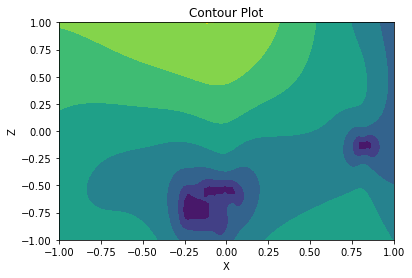

In [8]:
example = ntk[:,:,40]
fig, ax = plt.subplots(1, 1)
x = np.linspace(-1, 1, example.shape[0])
y = np.linspace(-1, 1, example.shape[1])
X, Y = np.meshgrid(x, y)
ax.contourf(X, Y, example.T)
  
ax.set_title('Contour Plot')
ax.set_xlabel('X')
ax.set_ylabel('Z')
plt.show()

## NTK reconstruction

Given the signed distance function representation (i.e. implicit representation), we are goingto reconstruct 3D meshes by marching cube algorithm

The given signed distance function, reconstruction result is shown as below:

In [9]:

#c = ntk.reshape(nb,nb,nb)
verts, faces, normals, values = measure.marching_cubes_lewiner(ntk, level=0.0, spacing=voxel_size)
tri_mesh = trimesh.Trimesh(np.asarray(verts), np.asarray(faces),
                          vertex_normals=np.asarray(normals))
tri_mesh.visual.vertex_colors = trimesh.visual.random_color()
tri_mesh.show()

In [10]:
# save file 
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.triangle_normals = o3d.utility.Vector3dVector(normals)
o3d.io.write_triangle_mesh("plane_spline.ply", mesh)

True

## NNGP reconstruction

We reconstruct 3D meshes from the implicit representation computed by NNGP 

In [11]:
verts, faces, normals, values = measure.marching_cubes_lewiner(nngp, level=0.0, spacing=voxel_size)  # convert sign distance function to 3D meshes by marching cube algorithm
tri_mesh = trimesh.Trimesh(np.asarray(verts), np.asarray(faces),vertex_normals=np.asarray(normals))
tri_mesh.visual.vertex_colors = trimesh.visual.random_color()
tri_mesh.show()

In [12]:
# save file
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.triangle_normals = o3d.utility.Vector3dVector(normals)
#o3d.io.write_triangle_mesh("cup_vari_nngp_1_1000_IGR_sample2048.ply", mesh)